**Check**

- [x] Check the expression for derivatives and break it down; Checked.

# Graph Constructor for Differential Equations

To solve the differential equation, we require a graph that represents the structure of differential equation.

Suppose we are solving the equation
$$
\frac{dy(t)}{dt} = y.
$$
The graph for $y(t)$  can be constructed easily in PyTorch. However, we need to find a way to construct the complete network that represents the differential equation, thus we need another graph that represents $dy/dt$.

In general, we approximate the function $y(t)$ as
$$
y(x_i) = y(x_{init}) + x_i \sum_k v_k R(t_i w_k + u_k)
$$
which leads to the approximation of $dy/dt$

The derivative can be approximated using
$$
\frac{dy}{dx}(x_i) = \sum_k v_k R(t_i w_k + u_k) + x_i \sum_k v_k R'(t_i w_k + u_k) w_k
$$

In [1]:
# Import modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('seaborn-poster')

In [66]:
# Construct the network for y

dtype=torch.Tensor

## Number of input
N = 10
## number of neurons
H = 10

learning_rate = 1e-6

data_x = np.linspace(0,1,N)
data_ones = np.ones(N)
data_ones_h = np.ones(H)
data_train = np.zeros(N)

ta_x = Variable( torch.from_numpy( data_x ).type(dtype), requires_grad=False )
ta_ones = Variable( torch.from_numpy( data_ones ).type(dtype), requires_grad=False )
ta_data_train = Variable( torch.from_numpy(data_train).type(dtype), requires_grad=False )

ta_v = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_w = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_u = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_ones_h =  Variable( torch.from_numpy( data_ones_h ).type(dtype), requires_grad=False )



In [67]:
act = nn.Sigmoid()

In [68]:
ta_trial_data = []

for t in range(500000):
    
#     ta_y_pred = ta_x.mm( ta_w1 ).clamp( min=0 ).mm(ta_w2)
#     print( torch.matmul( ta_v,act(torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ) ) )
    ta_data_pred = 1 + ta_x * ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) )
    ta_data_derivative = ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) ) + ta_x *  ( torch.matmul( ta_w*ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) * ( 1 - act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  )  )  )      ) )
    
    ta_loss = (ta_data_derivative + ta_data_pred ).pow(2).sum()
    
    ta_loss.backward()
    
    ta_v.data -= learning_rate* ta_v.grad.data
    ta_w.data -= learning_rate* ta_w.grad.data
    ta_u.data -= learning_rate* ta_u.grad.data
    
    ta_v.grad.data.zero_()
    ta_w.grad.data.zero_()
    ta_u.grad.data.zero_()
    
    ta_trial_data.append( [t, ta_loss.data[0]] )

#     print(t, ta_loss.data[0])



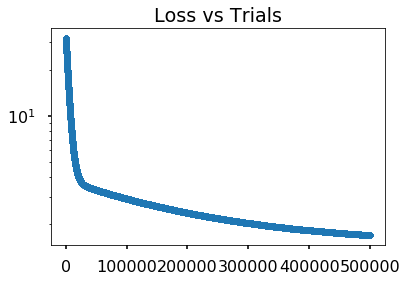

In [69]:
ta_trial_data_plt = np.transpose(ta_trial_data)
plt.semilogy( ta_trial_data_plt[0], ta_trial_data_plt[1], '.' )
plt.title('Loss vs Trials')
plt.show()

# Reconstruct the Function

In [70]:
test_data = 1 + ta_x * ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) )

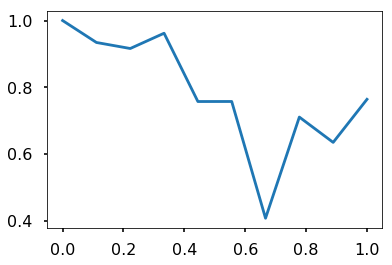

In [71]:
plt.plot(data_x, test_data.data.numpy() )